![baner_dogs](http://www.mf-data-science.fr/images/projects/dogs.jpg)
<h1><div style="padding:5px; margin-top:-40px; background: #343434; border-bottom: 2px solid #e4bf13; color:white; text-align:center !important;" id="intro">Détection de race de chien<br/>à partir d'images grâce aux <br/>réseaux de neurones à convolution</div></h1>

L'objectif de ce Notebook est de détailler la mise en place d'un **algorithme de détection de la race du chien sur une photo**, afin d'accélérer le travail d’indexation dans une base de données.

### Les contraintes imposées :
- **Pré-processer les images** avec des techniques spécifiques *(e.g. whitening, equalization, éventuellement modification de la taille des images)*.
- Réaliser de la **data augmentation** *(mirroring, cropping...)*.
- Mise en oeuvre de 2 approches de l'utilisation des CNN :
    - Réaliser un réseau de neurones CNN from scratch en optimisant les paramètres.     
    - Utiliser le transfert learning et ainsi utiliser un réseau déjà entrainé.
    
### Repo et interface de test en ligne :
Un repo Git est disponible pour ce projet à l'adresse : https://github.com/MikaData57/ingenieur-ml-computer-vision-cnn.
Ce repo reprend ce Notebook versionné ainsi que l'architecture de déploiement sur Heroku *(spécifique pour Tensorflow, OpenCV et Gradio)*.

Pour tester le modèle online sur Heroku : https://dogs-breeds-detection-cnn.herokuapp.com/

<h1><span style="color:#343434" id="sommaire">Sommaire</span></h1>

1. [Preprocessing des images](#section_1)     
    1.1. [Visualisation de la liste des races (classes) et un exemple de données](#section_1_1)     
    1.2. [Modification de la taille des images](#section_1_2)     
    1.3. [Modification des histogrammes des images](#section_1_3)      
    1.4. [Application de filtres](#section_1_4)      
    1.5. [Augmentation de données](#section_1_5)      
    1.6. [Fonction de traitement par lot pour le preprocessing](#section_1_6)      
    
2. [Modèle CNN from scratch](#section_2)      
    2.1. [Préparation des données pour le modèle CNN](#section_2_1)      
    2.2. [Construction du modèle CNN](#section_2_2)      
    2.3. [Entrainement et évaluation du modèle CNN](#section_2_3)      

3. [Transfert Learning : Modèle CNN pré-entrainé Xception](#section_3)      
    3.1. [Importation du modèle Xception pré-entrainé](#section_3_1)      
    3.2. [Entrainement du nouveau classifier sur Xception](#section_3_2)      
    3.3. [Comparaison avec l'architecture du modèle ResNet50](#section_3_3)      
    3.4. [Optimization des paramètres sur la couche classifier du modèle Xception](#section_3_4)      
    
4. [Xception fine tuning](#section_4)    
5. [Evaluation Xception fine tuned sur données test](#section_5)      
6. [Interface de prédiction sur de nouvelles données](#section_6)

In [1]:
! pip install gradio

     |████████████████████████████████| 2.6 MB 593 kB/s eta 0:00:01     |███████████████████▉            | 1.6 MB 593 kB/s eta 0:00:02
     |████████████████████████████████| 1.9 MB 5.2 MB/s eta 0:00:01
     |████████████████████████████████| 206 kB 6.7 MB/s eta 0:00:01
     |████████████████████████████████| 63 kB 2.1 MB/s eta 0:00:011
     |████████████████████████████████| 961 kB 6.7 MB/s eta 0:00:01
  Created wheel for ffmpy: filename=ffmpy-0.3.0-py3-none-any.whl size=4709 sha256=0e585fbab8eca21a5a4a027c5b140688f36c117842515688454eecc386aa3a5d
  Stored in directory: /root/.cache/pip/wheels/13/e4/6c/e8059816e86796a597c6e6b0d4c880630f51a1fcfa0befd5e6
  Created wheel for flask-cachebuster: filename=Flask_CacheBuster-1.0.0-py3-none-any.whl size=3372 sha256=55930b07fcd190380ab4d1c77eecb6cd28ba38d38f0e89b28946e34e01802c85
  Stored in directory: /root/.cache/pip/wheels/28/c0/c4/44687421dab41455be93112bd1b0dee1f3c5a9aa27bee63708
Successfully built ffmpy flask-cachebuster


In [2]:
# Import libraries
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import timeit
import cv2 as cv
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix 

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from keras import backend as K
import kerastuner as kt
from keras.models import load_model

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense

import gradio as gr

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.


In [3]:
warnings.filterwarnings('ignore')

In [4]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# <span style="color:#343434" id="section_1">1. Preprocessing des images</span>

Un des modules imposé dans ce Notebook est d'utiliser le **transfert learning**. Une liste des applications et modèles pré-entrainés de Keras est disponible à l'adresse : https://keras.io/api/applications/.

Nous allons dans un premier temps sélectionner le modèle que nous allons utiliser car en dépendra notamment la **taille des images à utiliser** *(et donc le redimensionnement à effectuer)*. Nous allons sélectionner un modèle :
* Performant *(avec une bonne Accuracy)*,
* De taille contenue pour des raisons matérielles et logistiques,
* Avec une profondeur moyenne pour ne pas surcharger les temps de calculs.

Sur ces critères, le modèle **Xception** semble adapté pour notre transfert learning : Taille de 88 MB, Top-5 Accuracy à 0.945 et Depth à 126. **Les images en entrée de ce modèle seront de 299px x 299px**. Nous testerons également une seconde architecture pour comparer les résultats obtenus. Nous testerons donc l'architecture **ResNet50**.

Pour commencer, nous allons rapidement analyser les données en regardant notamment l'état de répartition des races de chiens dans le répertoire images :

## <span style="color:#343434" id="section_1_1">1.1. Visualisation de la liste des races *(classes)* et un exemple de données.</span>

In [5]:
# Define path to data
annotations_dir = '../input/stanford-dogs-dataset/annotations/Annotation' 
images_dir = '../input/stanford-dogs-dataset/images/Images'

In [6]:
# Count the number of classes (dogs breeds)
breed_list = os.listdir(images_dir)
print("Number of breeds in dataset:", (len(breed_list)))

Number of breeds in dataset: 120


120 races de chien sont donc présentes dans notre jeu de données, ce qui représente **120 classes pour notre classifier**.
Nous allons à présent compter le nombre d'images de chaque race afin de vérifier si la distribution est équitable entre les classes :

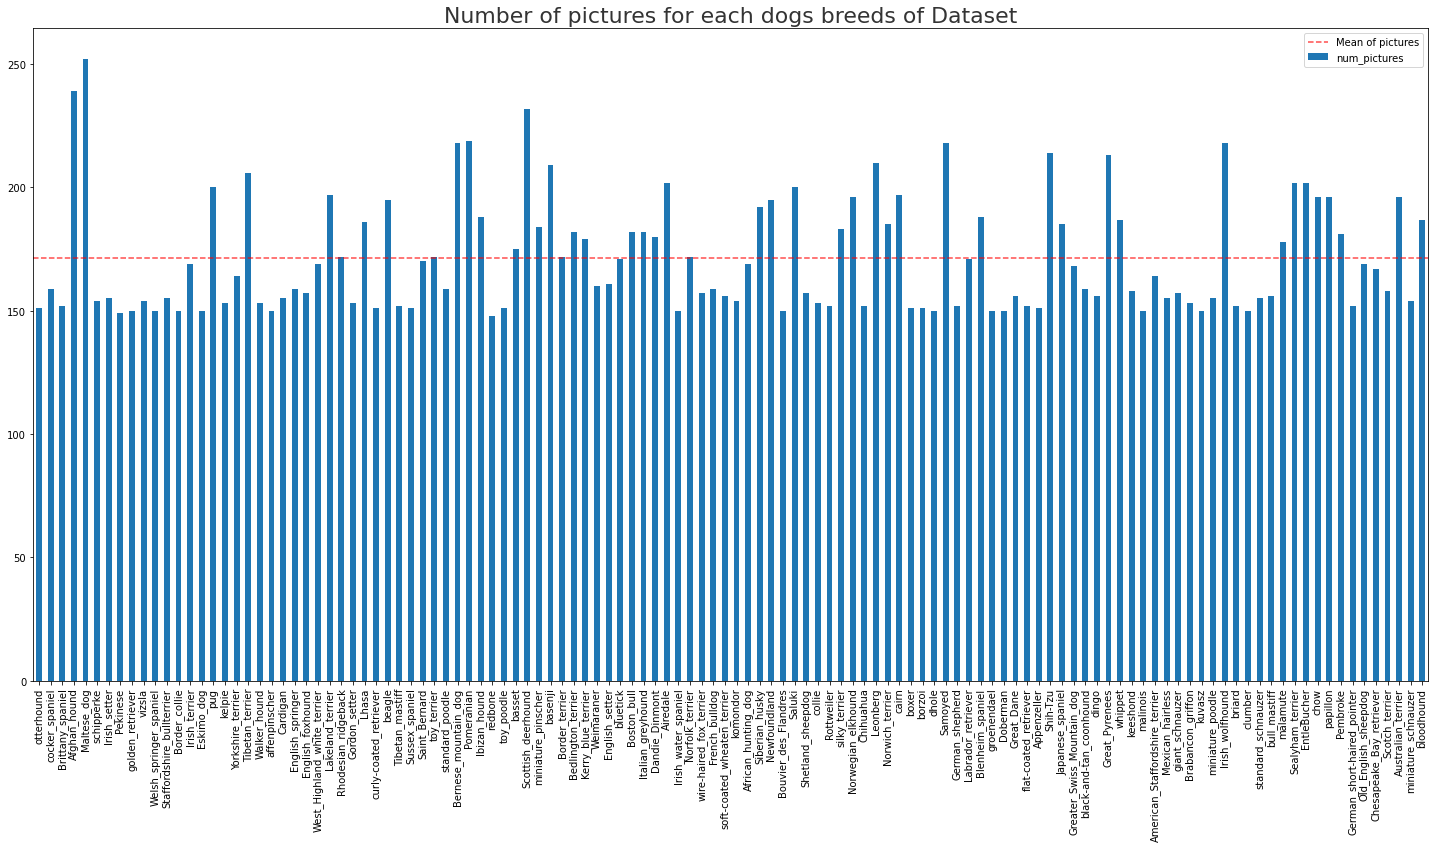

In [7]:
# Count number of pictures for each breed
df_breeds = pd.DataFrame(
    index=[breed.split('-',1)[1]
           for breed in breed_list],
    data=[len(os.listdir(images_dir + "/" + name))
          for name in breed_list],
    columns=["num_pictures"])

# Plot results
fig, ax = plt.subplots(1, 1, figsize=(25,12))
df_breeds.plot(kind="bar",
               legend=False,
               ax=ax)
ax.axhline(df_breeds["num_pictures"].mean(),
           color='r', alpha=.7,
           linestyle='--',
           label="Mean of pictures")
plt.title("Number of pictures for each "\
          "dogs breeds of Dataset",
          color="#343434", fontsize=22)
plt.legend()
plt.show()

On remarque que les races de chien sont toutes bien alimentées en images. La moyenne se situe à 171 photos par classe. Aucune race n'est sous représentée nous pouvons donc toutes les conserver pour le moment.

**Regardons quelques exemples des photos par races** disponibles dans la base d'étude :

In [8]:
def show_images_classes(path, classes, num_sample):
    """This function is used to display the first 
    n images of a directory passed as an argument. 
    It is adapted to subdirectories. 
    
    The matplotlib.image library must be loaded 
    with the alias mpimg. 

    Parameters
    ----------------------------------------
    path : string
        Link of root directory
    classes : string 
        Name of the subdirectory
    num_smaple : integer
        Number of picture to show
    ----------------------------------------
    """
    fig = plt.figure(figsize=(20,20))
    fig.patch.set_facecolor('#343434')
    plt.suptitle("{}".format(classes.split("-")[1]), y=.83,
                 color="white", fontsize=22)
    images = os.listdir(path + "/" + classes)[:num_sample]
    for i in range(num_sample):
        img = mpimg.imread(path+"/"+classes+"/"+images[i])
        plt.subplot(num_sample/5+1, 5, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

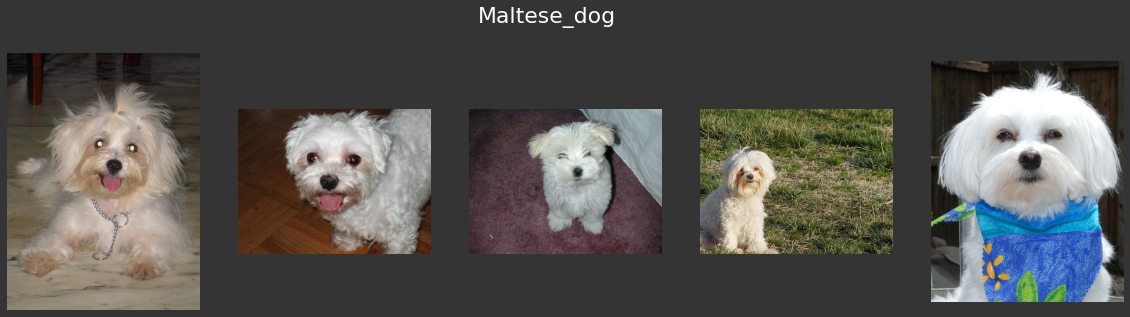

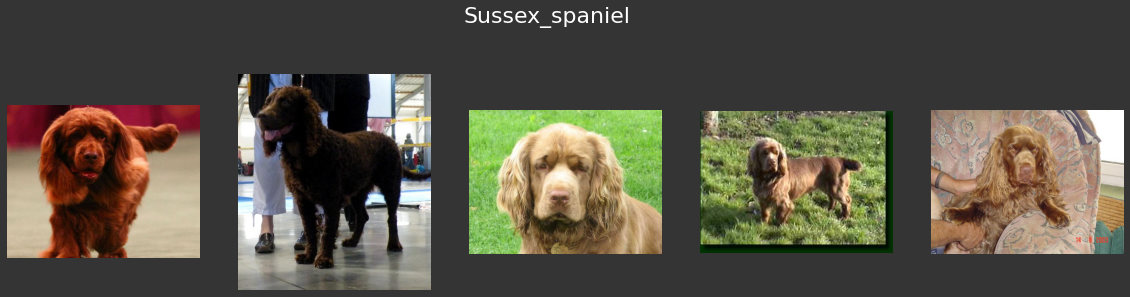

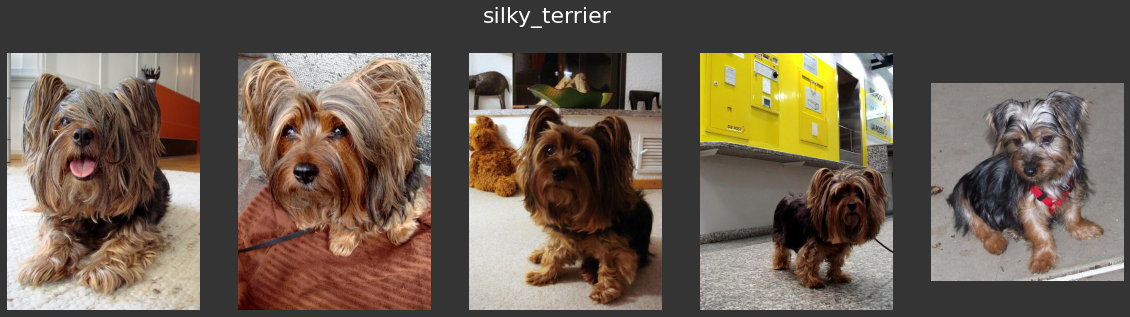

In [9]:
for i in np.random.randint(0, len(breed_list), size=3):
    show_images_classes(images_dir, breed_list[i], 5)

Nous allons devoir **modifier la taille des images** pour qu'elles s'adaptent aux contraintes du modèle CNN de transfert learning. Cela aura également pour effet de diminuer les temps de calculs de notre modèle "from scratch".

## <span style="color:#343434" id="section_1_2">1.2. Modification de la taille des images</span>

On peut remarquer dans les images en exemple ci-dessus que les chiens présents sur les photos ne sont pas toujours au centre de la photo, que les zooms sont différents. Redimensionner les images ne va pas changer ces attributs, **l'image va même être déformée** pour coller au nouvelles dimensions.

Nous allons réaliser la transformation sur une image test pour commencer.

In [10]:
# Define test image
img_test = (images_dir 
            + "/" 
            + "n02085782-Japanese_spaniel/n02085782_1626.jpg")
img_test = cv.imread(img_test)

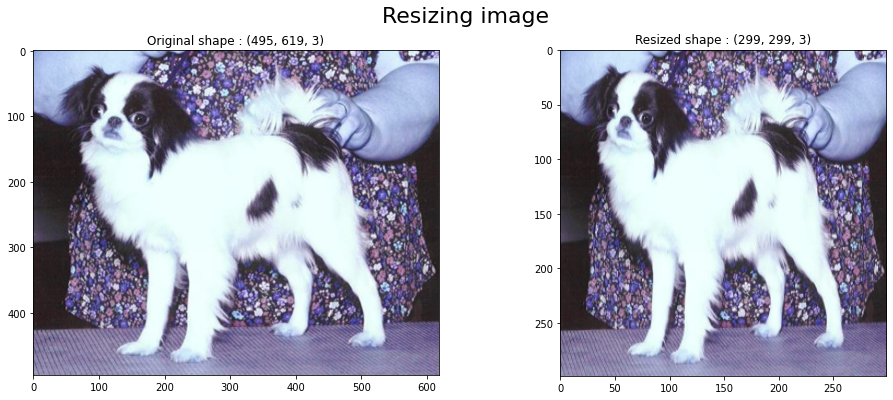

In [11]:
# setting dim of the resize
height = 299
width = 299
dim = (width, height)
# resize image with OpenCV
res_img = cv.resize(img_test, dim, interpolation=cv.INTER_LINEAR)

# Show both img
fig = plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plt.imshow(img_test)
plt.title("Original shape : {}".format(img_test.shape))
plt.subplot(1, 2, 2)
plt.imshow(res_img)
plt.title("Resized shape : {}".format(res_img.shape))
plt.suptitle("Resizing image",
             color="black", 
             fontsize=22, y=.98)
plt.show()

On voit bien ici que le redimensionnement en 299 x 299 déforme la photo initiale. **Une fois ce filtre appliqué à toutes les images, elles seront probablement toutes déformées**.

Autre fait, avec un set d'image relativement important, les expositions, contraste, ... sont relativement différents pour chaque photo. Nous allons à présent utiliser des méthodes basées sur les histogrammes de ces images pour pre-processer au mieux ces données.

## <span style="color:#343434" id="section_1_3">1.3. Modification de l'histogramme des images</span>

L'histogramme d'une image numérique est une courbe statistique représentant la **répartition de ses pixels selon leur intensité**. Commençons par regarder une image en particulier.

Nous allons transformer l'image dans différents codages couleurs. Le système de codage **YUV** est créé depuis une source RVB. Il est codé en trois composantes : **Y** représente la luminance *(informations de luminosité)* tandis que les deux autres (**U** et **V**) sont des données de chrominance *(informations de couleur)*. Ce format nous permet de visualiser au mieux l'histogramme pour les 3 dimensions :

In [12]:
# Transform image with differents color sets
img_RGB = cv.cvtColor(img_test, cv.COLOR_BGR2RGB)
img_grayscale = cv.cvtColor(img_test, cv.COLOR_RGB2GRAY)
img_YUV = cv.cvtColor(img_test,cv.COLOR_BGR2YUV)

In [13]:
# Create histogram
def plot_histogram(init_img, convert_img):
    """Function allowing to display the initial
    and converted images according to a certain
    colorimetric format as well as the histogram
    of the latter. 

    Parameters
    -------------------------------------------
    init_img : list
        init_img[0] = Title of the init image
        init_img[1] = Init openCV image
    convert_img : list
        convert_img[0] = Title of the converted
        convert_img[1] = converted openCV image
    -------------------------------------------
    """
    hist, bins = np.histogram(
                    convert_img[1].flatten(),
                    256, [0,256])
    # Cumulative Distribution Function
    cdf = hist.cumsum()
    cdf_normalized = cdf * float(hist.max()) / cdf.max()

    # Plot histogram
    fig = plt.figure(figsize=(25,6))
    plt.subplot(1, 3, 1)
    plt.imshow(init_img[1])
    plt.title("{} Image".format(init_img[0]), 
              color="#343434")
    plt.subplot(1, 3, 2)
    plt.imshow(convert_img[1])
    plt.title("{} Image".format(convert_img[0]), 
              color="#343434")
    plt.subplot(1, 3, 3)
    plt.plot(cdf_normalized, 
             color='r', alpha=.7,
             linestyle='--')
    plt.hist(convert_img[1].flatten(),256,[0,256])
    plt.xlim([0,256])
    plt.legend(('cdf','histogram'), loc = 'upper left')
    plt.title("Histogram of convert image", color="#343434")
    plt.suptitle("Histogram and cumulative "\
                 "distribution for test image",
              color="black", fontsize=22, y=.98)
    plt.show()

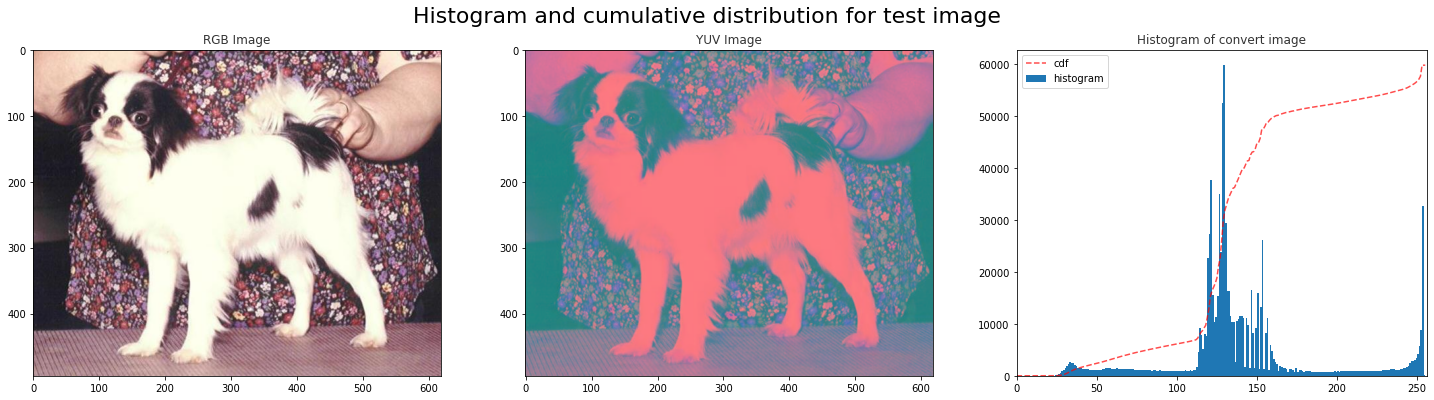

In [14]:
plot_histogram(["RGB", img_RGB], ["YUV", img_YUV])

### Egalisation

On constate ici des pics importants au centre de l'histogram. Dans le cadre d'une bonne égalisation (amélioration du contraste), il est nécessaire de répartir la lumière dans tout le spectre de l'image. 

**Testons l'égalisation avec OpenCV :**     
L'intérêt de convertir l'image dans l'espace colorimétrique YUV est de pouvoir agir sur le canal "luminance" (Y) indépendamment des autres canaux de chrominance. Nous allons donc réaliser l'égalisation sur ce seul canal Y :

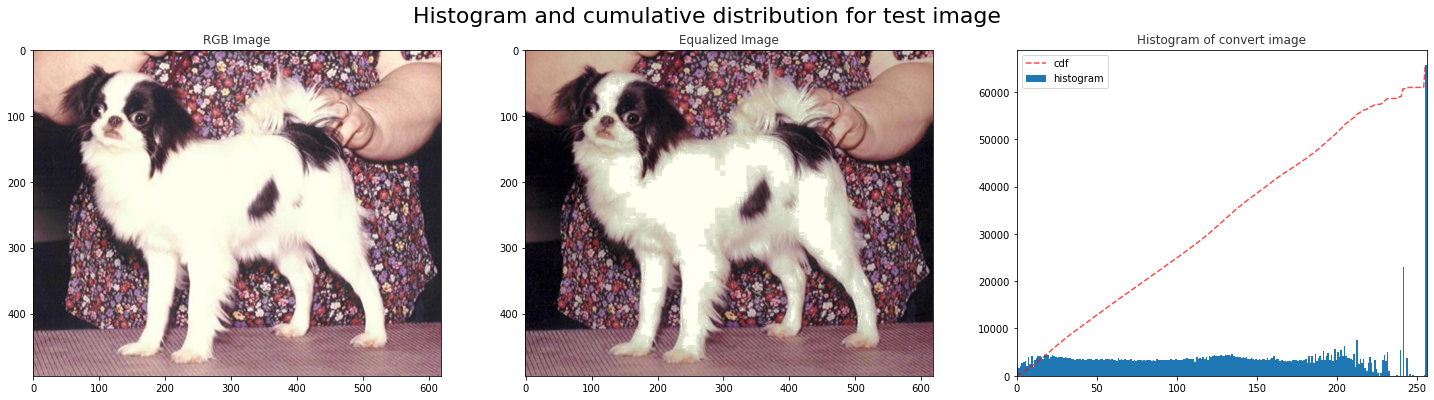

In [15]:
# Equalization
img_YUV[:,:,0] = cv.equalizeHist(img_YUV[:,:,0])
img_equ = cv.cvtColor(img_YUV, cv.COLOR_YUV2RGB)
plot_histogram(["RGB", img_RGB], ["Equalized", img_equ])

L'image résultante est donc bien égualisée, l'histogramme couvre l'ensemble du spectre et la CDF est constante et linéaire. **Ce pré-traitement sera donc appliqué à l'ensemble des images**.

## <span style="color:#343434" id="section_1_4">1.4. Application de filtres</span>
Les images peuvent pour de nombreuses raisons être bruitées, c'est à dire comporter des pixels atypiques qui peuvent fausser la détection de features. Par exemple de causes de bruits :
* Caractéristiques de l'appareil photo,
* Compression des images JPEG
* Mauvaise résolution ...

Pour pallier au bruit présent dans les images, il est possible d'appliquer un filtre. Il en existe de plusieurs types : les filtres linéaires (comme le filtre Gaussien), non linéaires comme le filtre médian par exemple.      
un des meilleurs filtre pour débruiter l'image est le **filtre non-local means**.


### Filtre non-local means
Contrairement aux filtres « moyenne locale », qui prennent la valeur moyenne d'un groupe de pixels entourant un pixel cible pour lisser l'image, le filtrage des moyennes non locales prend une moyenne de **tous les pixels de l'image**, pondérée par la similarité de ces pixels avec le pixel cible. Cela se traduit par une clarté de post-filtrage beaucoup plus grande et moins de perte de détails dans l'image par rapport aux algorithmes de moyenne locale.

Testons ce fitre sur notre image test :

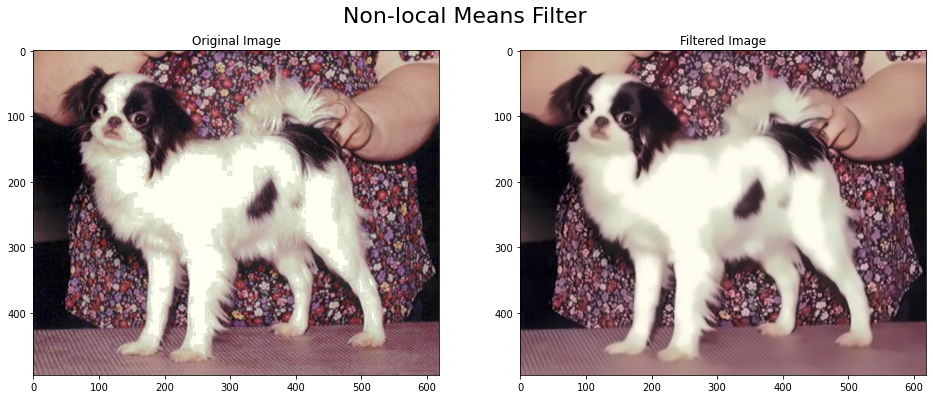

In [16]:
# Apply non-local means filter on test img
dst_img = cv.fastNlMeansDenoisingColored(
    src=img_equ,
    dst=None,
    h=10,
    hColor=10,
    templateWindowSize=7,
    searchWindowSize=21)

# Show both img
fig = plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plt.imshow(img_equ)
plt.title("Original Image")
plt.subplot(1, 2, 2)
plt.imshow(dst_img)
plt.title("Filtered Image")
plt.suptitle("Non-local Means Filter",
             color="black", 
             fontsize=22, y=.98)
plt.show()

## <span style="color:#343434" id="section_1_5">1.5. Augmentation de données</span>

Le risque sur ce type de dataset comportant peu de données (20 000 images) est de sur-entrainer notre modèle, il ne pourra pas développer des règles de décisions pouvant être généralisé à de nouvelles données. Il faut donc augmenter le nombre de data et pour cela, nous allons utiliser la **Data Augmentation**.

L'objectif de la data augmentation est de reproduire les images préexistantes en leur appliquant une **transformation aléatoire**. Pour cela, Keras mets à disposition la méthode `ImageDataGenerator` qui permet de faire à la fois du mirroring, de la rotation, des zoom ... et ce de manière aléatoire !

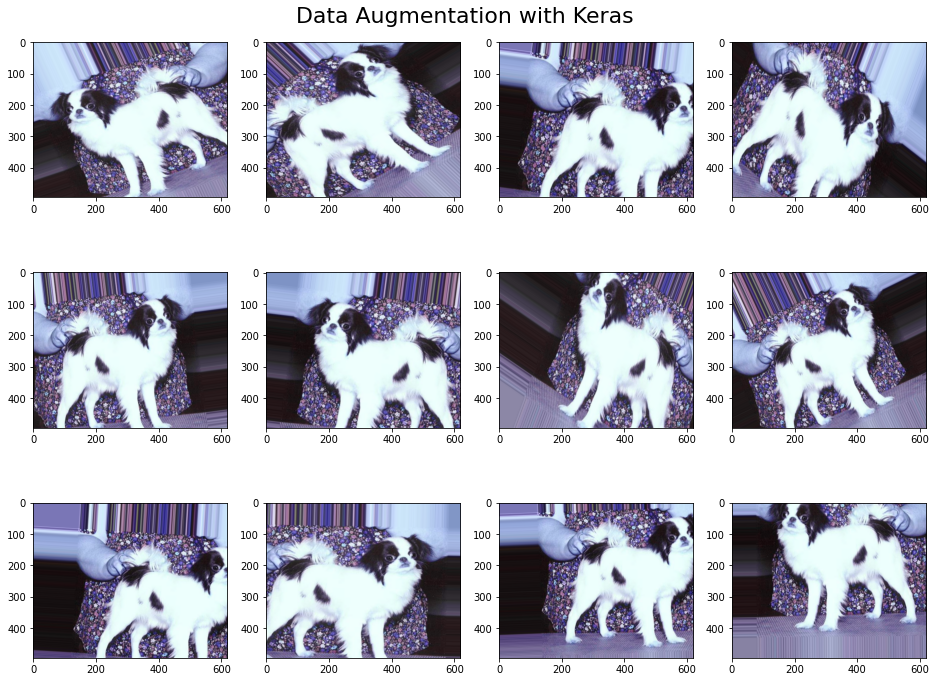

In [17]:
#Initilize Data Generator Keras
augmented_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Convert test img to array
x = image.img_to_array(img_test)
x = x.reshape((1,) + x.shape)

i=0
fig = plt.figure(figsize=(16,12))
for batch in augmented_datagen.flow(x, batch_size=1):
    ax = fig.add_subplot(3,4,i+1)
    ax.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 12 == 0:
        break

plt.suptitle("Data Augmentation with Keras",
             color="black", 
             fontsize=22, y=.90)
plt.show()


La méthode de Data Augmentation nous permet d'obtenir des images avec différents zoom, des effets mirroir et des rotations qui vont donc augmenter notre base d'images significativement et efficacement.

## <span style="color:#343434" id="section_1_6">1.6. Fonction de traitement par lot pour le preprocessing</span>

Nous allons déjà tester les fonctions et la classification sur un nombre restreint de race de chien afin de limiter les temps de calcul. Constuisons la fonction de preprocessing qui retournera les labels et images :

In [18]:
def preprocessing_cnn(directories, img_width, img_height):
    """Preprocessing of images in order to integrate them 
    into a convolutional neural network. Equalization, 
    Denoising and transformation of the image into Array. 
    Simultaneous creation of labels (y). 

    Parameters
    ---------------------------------------------------
    directoriesList : list
        List of files to be processed.
    img_width : integer
        width of the image to be reached for resizing
    img_height : integer
        height of the image to be reached for resizing
    ---------------------------------------------------
    """
    img_list=[]
    labels=[]
    for index, breed in enumerate(directories):
        for image_name in os.listdir(images_dir+"/"+breed):
            # Read image
            img = cv.imread(images_dir+"/"+breed+"/"+image_name)
            img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
            # Resize image
            dim = (img_width, img_height)
            img = cv.resize(img, dim, interpolation=cv.INTER_LINEAR)
            # Equalization
            img_yuv = cv.cvtColor(img,cv.COLOR_BGR2YUV)
            img_yuv[:,:,0] = cv.equalizeHist(img_yuv[:,:,0])
            img_equ = cv.cvtColor(img_yuv, cv.COLOR_YUV2RGB)
            # Apply non-local means filter on test img
            dst_img = cv.fastNlMeansDenoisingColored(
                src=img_equ,
                dst=None,
                h=10,
                hColor=10,
                templateWindowSize=7,
                searchWindowSize=21)
            
            # Convert modified img to array
            img_array = image.img_to_array(dst_img)
            
            # Append lists of labels and images
            img_list.append(np.array(img_array))
            labels.append(breed.split("-")[1])
    
    return img_list, labels

Nous allons créer et entrainer les modèles sur **15 des 20 races de chiens les plus populaires en France en 2020** selon l'étude de [centrale-canine.fr](https://www.centrale-canine.fr/actualites/lof-2020-les-races-de-chiens-preferees-des-francais). Cet algorithme pourra ensuite être étendu à l'ensemble des races s'il est satisfaisant.

In [19]:
fr_breed_list = [
    'n02096294-Australian_terrier',
    'n02093256-Staffordshire_bullterrier',
    'n02099601-golden_retriever',
    'n02106662-German_shepherd',
    'n02086240-Shih-Tzu',
    'n02099712-Labrador_retriever',
    'n02088364-beagle',
    'n02100735-English_setter',
    'n02102318-cocker_spaniel',
    'n02108915-French_bulldog',
    'n02094433-Yorkshire_terrier',
    'n02085620-Chihuahua',
    'n02110185-Siberian_husky',
    'n02106166-Border_collie',
    'n02106550-Rottweiler']

In [20]:
# Define numbers of breeds to preprocess
num_breeds = len(fr_breed_list) 

# Execute preprocessor on selection
start_time = timeit.default_timer()
# X = images
# y = labels
X, y = preprocessing_cnn(fr_breed_list, 299, 299)
# Convert in numpy array
X = np.array(X)
y = np.array(y)
preprocess_time = timeit.default_timer() - start_time
print("-" * 50)
print("Execution time for preprocessing :")
print("-" * 50)
print("Number of images preprocessed : {}"\
     .format(len(y)))
print("Shape of images np.array : {}"\
     .format(X.shape))
print("Total time : {:.2f}s".format(preprocess_time))

--------------------------------------------------
Execution time for preprocessing :
--------------------------------------------------
Number of images preprocessed : 2522
Shape of images np.array : (2522, 299, 299, 3)
Total time : 683.93s


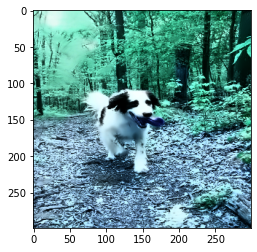

In [21]:
# Show exemple preprocessed image
plt.imshow(image.array_to_img(X[1234]))

# <span style="color:#343434" id="section_2">2. Modèle CNN from scratch</span>

A présents, nos images test ont été pré-traitées grâce notamment à l'égalisation, le débruitage et le redimensionnement. Nous avons créé des listes de tableaux Numpy regroupant les images sous format numériques.      
Pour entrainer notre premier modèle, nous devons dans un premier temps **mélanger les images** car actuellement, toutes les photos d'une même race se suivent.

## <span style="color:#343434" id="section_2_1">2.1. Préparation des données pour le modèle CNN</span>
Nous allons donc mélanger les datas dans X et y pour le premier passage dans le réseau. Ce brassage a pour objectif de réduire la variance et de s'assurer que les modèles ne soient pas sur-entraînés.

In [22]:
# Using np.shuffle
img_space = np.arange(X.shape[0])
np.random.seed(8)
# Shuffle the space
np.random.shuffle(img_space)
# Apply to X and y in same order
X = X[img_space]
y = y[img_space]

Les images sont à présent mélangées. Pour les modélisations Keras, il faut également modifier les types de nos données X et convertir nos données à prédire (y) en variable numérique. En effet, pour le moment, ce sont des données textuelles qui sont stockées dans y. Nous allons donc utiliser un simple ***LabelEncoder*** pour les convertir.

In [23]:
# Change X type 
X = X.astype(np.float32)
# Encode y text data in numeric
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)

In [24]:
# Verifie encoder created classes
print(encoder.classes_)

['Australian_terrier' 'Border_collie' 'Chihuahua' 'English_setter'
 'French_bulldog' 'German_shepherd' 'Labrador_retriever' 'Rottweiler'
 'Shih' 'Siberian_husky' 'Staffordshire_bullterrier' 'Yorkshire_terrier'
 'beagle' 'cocker_spaniel' 'golden_retriever']


A présent, nous pouvons **créer les sets d'entrainement et de test qui serviront à l'entrainement de nos modèles**. Le set de **validation** quant à lui sera créé directement dans le générateur Keras.

In [25]:
### Create train and test set
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print("-" * 50)
print("Size of created sets :")
print("-" * 50)
print("Train set size = ",x_train.shape[0])
print("Test set size = ",x_test.shape[0])

--------------------------------------------------
Size of created sets :
--------------------------------------------------
Train set size =  2017
Test set size =  505


Dernière étape de la préparation, nous allons **créer les générateurs Keras** pour les sets de données en incluant la **Data Augmentation pour le jeu d'entrainement** :

In [26]:
# Data generator on train set with Data Augmentation
# Validation set is define here
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2)

#For validation and test, just rescale
test_datagen = ImageDataGenerator(rescale=1./255)

Ces générateurs seront ainsi utilisés dans les pipeline de modélisation Keras.

## <span style="color:#343434" id="section_2_2">2.2. Construction du modèle CNN</span>
Nous allons ici initialiser un premier modèle de réseau de neurones à convolution en imbriquant plusieurs couches :
- **Couches de convolution** : Son but est de repérer la présence d'un ensemble de features dans les images reçues en entrée. Pour cela, on réalise un filtrage par convolution.
- **Couches de Pooling** : L'opération de pooling consiste à réduire la taille des images, tout en préservant leurs caractéristiques importantes.
- **Couches de correction ReLU** : La couche de correction ReLU remplace toutes les valeurs négatives reçues en entrées par des zéros. Elle joue le rôle de fonction d'activation.
- **Couches Fully connected** : Ce type de couche reçoit un vecteur en entrée et produit un nouveau vecteur en sortie. Pour cela, elle applique une combinaison linéaire puis éventuellement une fonction d'activation aux valeurs reçues en entrée.
- **DropOut** : La méthode du dropout consiste à « désactiver » des sorties de neurones aléatoirement pour éviter le sur-entraînement.

Pour notre modèle, nous allons tester une architecture simple, pas trop profonde qui nous servira de baseline pour les procheins modèles. Nous allons donc implémenter uniquement 3 couches de convolution.

Nous allons également définir des **métriques plus précises que Accuracy** pour l'évaluation de notre modèle, comme par exemple le ***Score F1*** qui combine *precision* et *recall* :

In [27]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

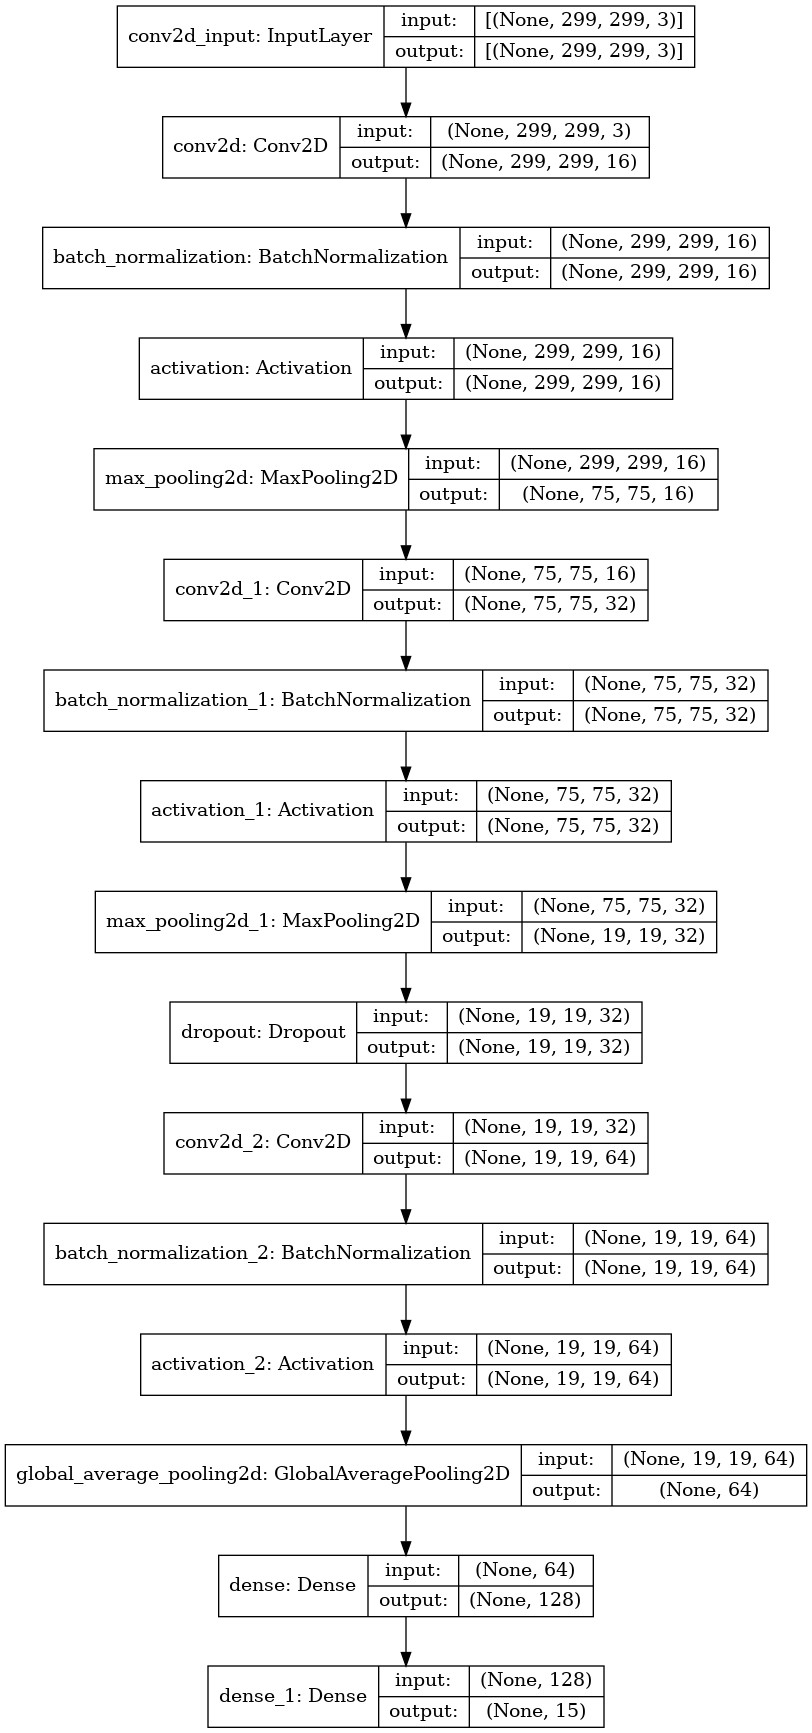

In [28]:
K.clear_session()
model = Sequential()
# Convolution layer
model.add(Conv2D(filters=16,
                 kernel_size=(3,3), 
                 padding='same',
                 use_bias=False,
                 input_shape=(299,299,3)))
model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation('relu'))
# Pooling layer
model.add(MaxPooling2D(pool_size=(4, 4),
                       strides=(4, 4),
                       padding='same'))
# Second convolution layer
model.add(Conv2D(filters=32,
                 kernel_size=(3,3), 
                 padding='same',
                 use_bias=False))
model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))
model.add(Dropout(0.2))
# Third convolution layer
model.add(Conv2D(filters=64,
                 kernel_size=(3,3), 
                 padding='same',
                 use_bias=False))
model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation('relu'))
model.add(GlobalAveragePooling2D())
# Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(num_breeds, activation='softmax'))
plot_model(model, to_file='CNN_model_plot.png', 
           show_shapes=True, show_layer_names=True)

In [29]:
# Compile the CNN Model
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy", f1_m])

Notre modèle est créé, nous allons pouvoir l'**entrainer sur 50 époques grâce aux générateur précédement créés et stocker les résultats** pour ensuite les analyser :

## <span style="color:#343434" id="section_2_3">2.3. Entrainement et évaluation du modèle CNN</span>

In [30]:
history = model.fit(
    train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='training'),
    validation_data=train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='validation'),
    steps_per_epoch=len(x_train) / 32,
    epochs=20,
    verbose=2)

Epoch 1/20
63/63 - 32s - loss: 2.7094 - accuracy: 0.1006 - f1_m: 14.2291 - val_loss: 2.6920 - val_accuracy: 0.0918 - val_f1_m: 14.7939
Epoch 2/20
63/63 - 24s - loss: 2.6547 - accuracy: 0.1074 - f1_m: 13.5254 - val_loss: 2.6882 - val_accuracy: 0.0968 - val_f1_m: 13.8430
Epoch 3/20
63/63 - 26s - loss: 2.6352 - accuracy: 0.1184 - f1_m: 13.1033 - val_loss: 2.7045 - val_accuracy: 0.0819 - val_f1_m: 13.2204
Epoch 4/20
63/63 - 25s - loss: 2.6361 - accuracy: 0.1252 - f1_m: 13.0755 - val_loss: 2.8665 - val_accuracy: 0.0819 - val_f1_m: 10.7767
Epoch 5/20
63/63 - 25s - loss: 2.6100 - accuracy: 0.1191 - f1_m: 13.2489 - val_loss: 2.6374 - val_accuracy: 0.1489 - val_f1_m: 13.2838
Epoch 6/20
63/63 - 25s - loss: 2.5879 - accuracy: 0.1221 - f1_m: 12.6600 - val_loss: 2.6957 - val_accuracy: 0.0993 - val_f1_m: 11.1295
Epoch 7/20
63/63 - 25s - loss: 2.5792 - accuracy: 0.1301 - f1_m: 12.5082 - val_loss: 2.8492 - val_accuracy: 0.0744 - val_f1_m: 10.4015
Epoch 8/20
63/63 - 26s - loss: 2.5635 - accuracy: 0.140

In [31]:
def plot_history_scores(dict_history, first_score, second_score):
    with plt.style.context('seaborn-whitegrid'):
        fig = plt.figure(figsize=(25,10))
        # summarize history for accuracy
        plt.subplot(1, 2, 1)
        plt.plot(dict_history.history[first_score], color="g")
        plt.plot(dict_history.history['val_' + first_score],
                 linestyle='--', color="orange")
        plt.title('CNN model ' + first_score, fontsize=18)
        plt.ylabel(first_score)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        # summarize history for loss
        plt.subplot(1, 2, 2)
        plt.plot(dict_history.history[second_score], color="g")
        plt.plot(dict_history.history['val_' + second_score],
                 linestyle='--', color="orange")
        plt.title('CNN model ' + second_score, fontsize=18)
        plt.ylabel(second_score)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()

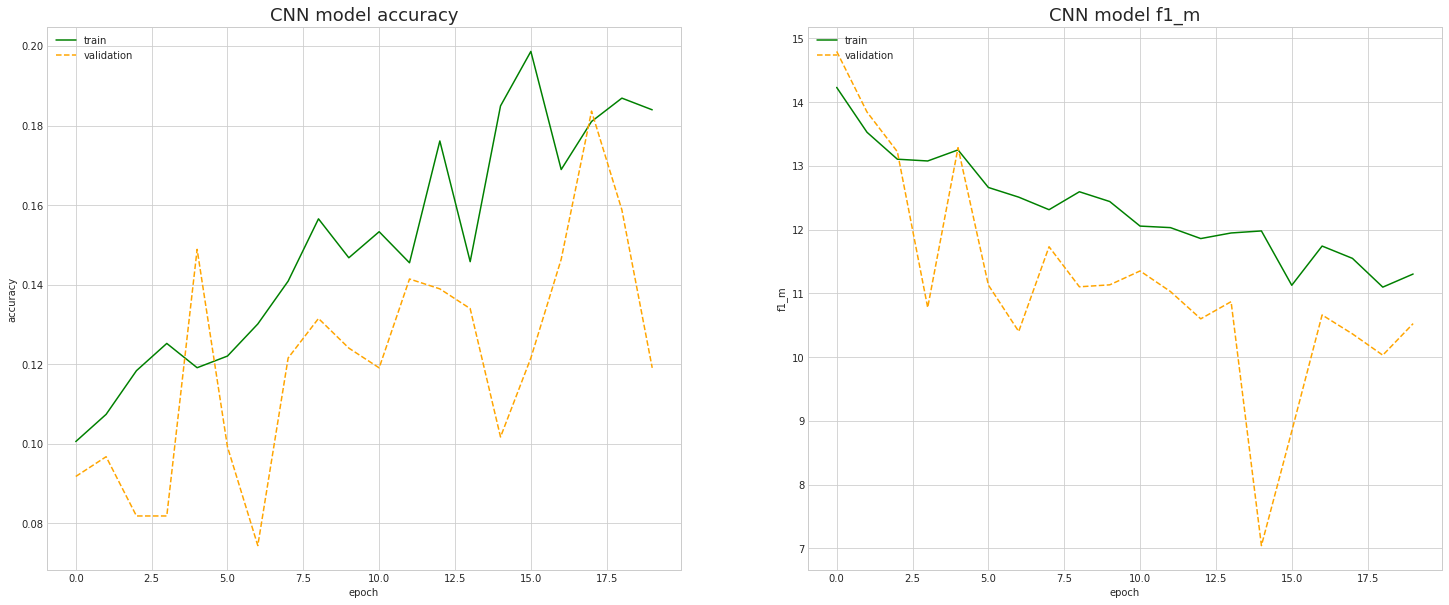

In [32]:
plot_history_scores(
    dict_history = history, 
    first_score = "accuracy", 
    second_score = "f1_m")

On voit que sur ce modèle CNN from scratch les métriques ne sont pas bonnes. L'Accuracy ne dépasse pas 13% et le score F1 est élevé et stable sur les 50 époques.

Nous allons maintenant tester des modèles pré-entrainés et vérifier si les performances sont meilleures comparées à notre baseline.

# <span style="color:#343434" id="section_3">3. Transfert Learning : Modèle CNN pré-entrainé Xception</span>
Le modèle Xception est dérivé de l'architecture Inception. Inception a pour but de réduire la consommation de ressources des CNN profonds. Il repose sur l'utilisation de blocs de traitement suivants :

![inception_block](http://www.mf-data-science.fr/images/projects/inception_block.png)

La dimension de l’image analysée est réduite par les filtres 3x3 et 5x5, en ajoutant une étape de filtrage 1x1 en amont. De cette façon, la convolution de taille 1x1 effectue une opération de pooling sur les valeurs d’un pixel dans l’espace des dimensions de l’image.      
Xception remplace les modules Inception par des modules de convolutions séparables en profondeur *(en anglais depthwise separable convolution)* et ajoute des liaisons résiduelles. Ce type d’approche permet de considérablement réduire l’utilisation de ressources lors du calcul matriciel, sans modifier le nombre de paramètres.      
*Pour en apprendre plus :* https://arxiv.org/abs/1610.02357

L'architecture Xception est la suivante :

![inception_block](http://www.mf-data-science.fr/images/projects/imagenet_xception_flow.png)

## <span style="color:#343434" id="section_3_1">3.1. Importation du modèle Xception pré-entrainé</span>

Chargeons le modèle de base pré-entrainé de Keras mais **sans les couches fully-connected**. **Nous allons ajouter notre propre classifier final**. 

In [33]:
K.clear_session()
# Import Xception trained model
xception_model = tf.keras.applications.xception.Xception(
    weights='imagenet',
    include_top=False, 
    pooling='avg',
    input_shape=(299,299,3))

# look at the differents layers
print("-" * 50)
print("Xception base model layers :")
print("-" * 50)
for layer in xception_model.layers:
    print(layer)

83689472/83683744 [==============================] - 1s 0us/step
--------------------------------------------------
Xception base model layers :
--------------------------------------------------


## <span style="color:#343434" id="section_3_2">3.2. Entrainement du nouveau classifier sur Xception</span>

Notre jeu de données est petit et relativement similaire au dataset original. Si nous entrainons le réseau complet, nous risquons de rencontrer des problèmes d'over-fitting. Nous allons donc **"geler" tous les layers de Xception et entrainer uniquement le classifier**.

In [34]:
for layer in xception_model.layers:
    layer.trainable = False

On remarque dans les layers importés du modèle que la dernière couche importée est une couche `GlobalAveragePooling2D`. Nous allons donc **ajouter une couche complétement connectée, un DropOut et enfin le classifier** dans un nouveau modèle :# <span style="color:#343434" id="section_1">1. Preprocessing des images</span>

In [35]:
# Add new fully-connected layers
base_output = xception_model.output
base_output = Dense(128, activation='relu')(base_output)
base_output = Dropout(0.2)(base_output)
# Output : new classifier
predictions = Dense(num_breeds, activation='softmax')(base_output)

# Define new model
my_xcept_model = Model(inputs=xception_model.input,
                       outputs=predictions)
my_xcept_model.compile(optimizer="adam",
                       loss="sparse_categorical_crossentropy",
                       metrics=["accuracy", f1_m])

In [36]:
Xception_plot = plot_model(my_xcept_model,
                           to_file='xcept_model_plot.png',
                           show_shapes=True,
                           show_layer_names=False)

Il est également nécessaire de modifier les générateurs pour y **intégrer le `preprocess_input` Xception** recommandé par Keras :

In [37]:
# Data generator on train set with Data Augmentation
# and preprocess_input Xception
# Validation set is define here
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2,
    preprocessing_function=tf.keras.applications.xception.preprocess_input)

#For validation and test, just rescale
test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input)

In [38]:
history_xcept = my_xcept_model.fit(
    train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='training'),
    validation_data=train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='validation'),
    steps_per_epoch=len(x_train) / 32,
    epochs=20,
    verbose=2)

Epoch 1/20
63/63 - 32s - loss: 1.7576 - accuracy: 0.4961 - f1_m: 7.3765 - val_loss: 1.0808 - val_accuracy: 0.6253 - val_f1_m: 3.2647
Epoch 2/20
63/63 - 28s - loss: 0.9587 - accuracy: 0.6869 - f1_m: 3.0641 - val_loss: 0.7842 - val_accuracy: 0.7841 - val_f1_m: 2.6956
Epoch 3/20
63/63 - 29s - loss: 0.7465 - accuracy: 0.7593 - f1_m: 2.5207 - val_loss: 0.7602 - val_accuracy: 0.7618 - val_f1_m: 2.3063
Epoch 4/20
63/63 - 27s - loss: 0.7208 - accuracy: 0.7710 - f1_m: 2.2310 - val_loss: 0.7464 - val_accuracy: 0.7444 - val_f1_m: 2.1611
Epoch 5/20
63/63 - 28s - loss: 0.6981 - accuracy: 0.7769 - f1_m: 2.2067 - val_loss: 0.6401 - val_accuracy: 0.7916 - val_f1_m: 2.1400
Epoch 6/20
63/63 - 28s - loss: 0.6705 - accuracy: 0.7730 - f1_m: 2.0966 - val_loss: 0.7798 - val_accuracy: 0.7519 - val_f1_m: 2.0270
Epoch 7/20
63/63 - 27s - loss: 0.6241 - accuracy: 0.7975 - f1_m: 2.1247 - val_loss: 0.6969 - val_accuracy: 0.7866 - val_f1_m: 1.9911
Epoch 8/20
63/63 - 28s - loss: 0.6010 - accuracy: 0.7916 - f1_m: 2.05

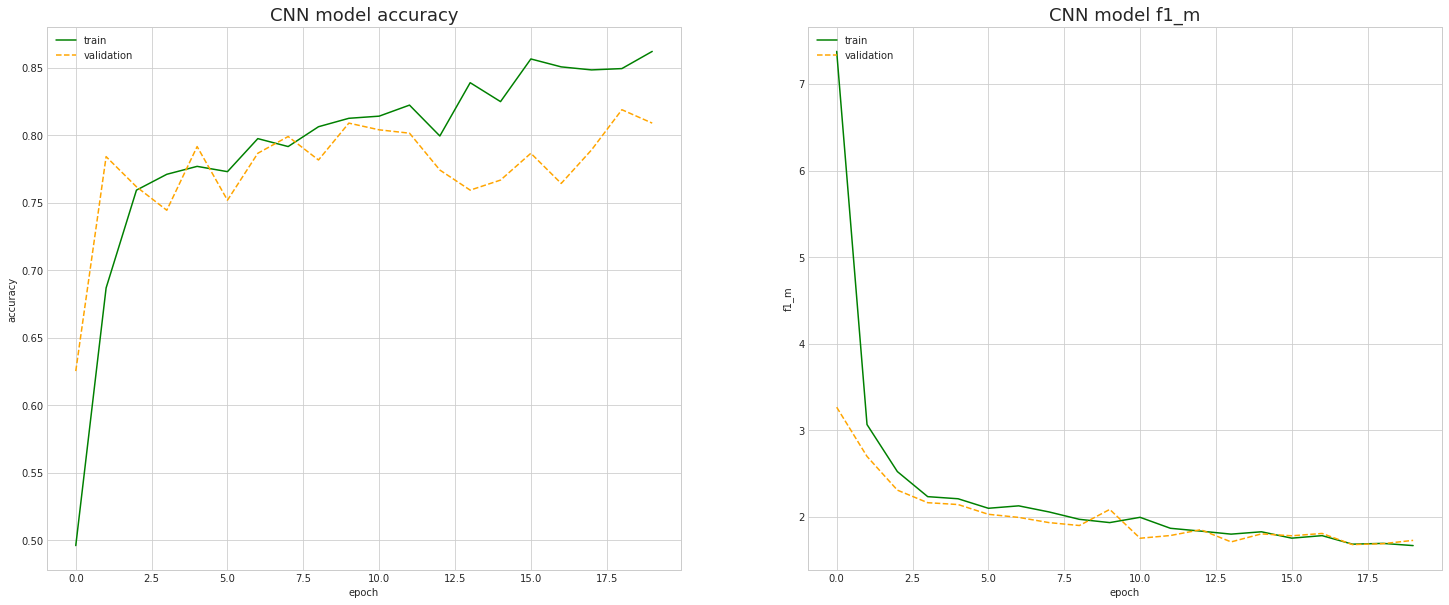

In [39]:
plot_history_scores(
    dict_history = history_xcept, 
    first_score = "accuracy", 
    second_score = "f1_m")

On voit très bien ici que les métriques du modèle Xception sur nos données sont bien meilleures que le modèle "from scratch" quand les couches profondes ne sont pas entrainées. D'autre part, le modèle apprend très vite et l'accuracy augmente rapidement *(tout comme la perte diminue)*. Comparons les 2 modèles :

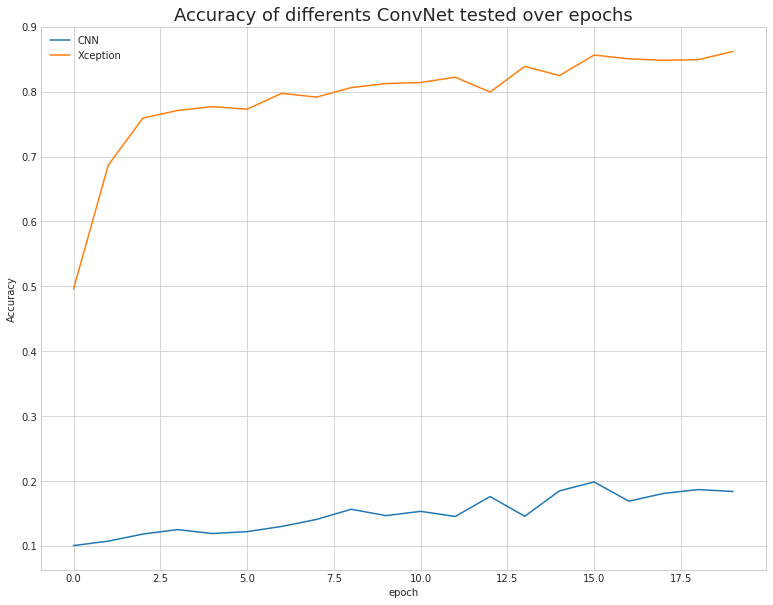

In [40]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(13,10))
    plt.plot(history.history['accuracy'],
             label='CNN')
    plt.plot(history_xcept.history['accuracy'],
             label='Xception')
    plt.title('Accuracy of differents ConvNet tested over epochs',
              fontsize=18)
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(loc='upper left')
    plt.show()

In [41]:
xcept_mean_accuracy = np.mean(history_xcept.history['val_accuracy'])
xcept_mean_f1 = np.mean(history_xcept.history['val_f1_m'])
print("-" * 50)
print("Xception base model validation Scores :")
print("-" * 50)
print("Mean validation accuracy: {:.2f}"\
      .format(xcept_mean_accuracy))
print("Mean validation F1 score: {:.2f}"\
      .format(xcept_mean_f1))

--------------------------------------------------
Xception base model validation Scores :
--------------------------------------------------
Mean validation accuracy: 0.78
Mean validation F1 score: 2.00


## <span style="color:#343434" id="section_3_3">3.3. Comparaison avec l'architecture du modèle ResNet50</span>

Dans un réseau de neurones à convolution profonde, plusieurs couches sont empilées et entraînées à la tâche à accomplir. Le réseau apprend plusieurs caractéristiques de niveau bas/moyen/haut à la fin de ses couches. Dans l'**apprentissage résiduel**, au lieu d'essayer d'apprendre certaines caractéristiques, le réseau apprend certaines caractéristiques résiduelles. Le résidu peut être simplement compris comme une soustraction d'une caractéristique apprise à partir de l'entrée de cette couche. **ResNet** le fait en utilisant des connexions de raccourci *(connectant directement l'entrée de la nième couche à une (n+x)ième couche)*. Son architecture est la suivante :

![ResNet50](http://www.mf-data-science.fr/images/projects/RenNet50.jpg)

In [42]:
 K.clear_session()
# Import ResNet50 trained model
resnet_model = tf.keras.applications.ResNet50(
    weights='imagenet',
    include_top=False, 
    pooling='avg',
    input_shape=(299,299,3))

# Dont retrain layers
for rn_layer in resnet_model.layers:
    rn_layer.trainable = False
    
# Add new fully-connected layers
rn_base_output = resnet_model.output
rn_base_output = Dense(128, activation='relu')(rn_base_output)
rn_base_output = Dropout(0.2)(rn_base_output)
# Output : new classifier
rn_predictions = Dense(num_breeds, activation='softmax')(rn_base_output)

# Define new model
my_resnet_model = Model(inputs=resnet_model.input,
                        outputs=rn_predictions)
my_resnet_model.compile(optimizer="adam",
                       loss="sparse_categorical_crossentropy",
                       metrics=["accuracy", f1_m])

# Data generator on train set with Data Augmentation
# and preprocess_input Resnet
# Validation set is define here
rn_train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2,
    preprocessing_function=tf.keras.applications.resnet.preprocess_input)

#For validation and test, just rescale
rn_test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet.preprocess_input)

94773248/94765736 [==============================] - 2s 0us/step


In [43]:
history_resnet = my_resnet_model.fit(
    rn_train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='training'),
    validation_data=rn_train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='validation'),
    steps_per_epoch=len(x_train) / 32,
    epochs=20,
    verbose=2)

Epoch 1/20
63/63 - 32s - loss: 2.5265 - accuracy: 0.1840 - f1_m: 9.5547 - val_loss: 2.0230 - val_accuracy: 0.3375 - val_f1_m: 8.5111
Epoch 2/20
63/63 - 26s - loss: 1.7834 - accuracy: 0.4170 - f1_m: 6.8739 - val_loss: 1.4957 - val_accuracy: 0.5161 - val_f1_m: 5.4825
Epoch 3/20
63/63 - 29s - loss: 1.4490 - accuracy: 0.5166 - f1_m: 5.1254 - val_loss: 1.2678 - val_accuracy: 0.5906 - val_f1_m: 5.3408
Epoch 4/20
63/63 - 28s - loss: 1.2612 - accuracy: 0.6027 - f1_m: 4.3589 - val_loss: 1.2295 - val_accuracy: 0.5931 - val_f1_m: 4.2188
Epoch 5/20
63/63 - 27s - loss: 1.1934 - accuracy: 0.5930 - f1_m: 3.8075 - val_loss: 1.0988 - val_accuracy: 0.6352 - val_f1_m: 3.6536
Epoch 6/20
63/63 - 28s - loss: 1.0708 - accuracy: 0.6289 - f1_m: 3.4716 - val_loss: 1.0831 - val_accuracy: 0.6352 - val_f1_m: 3.2309
Epoch 7/20
63/63 - 27s - loss: 1.0188 - accuracy: 0.6475 - f1_m: 3.2295 - val_loss: 1.0018 - val_accuracy: 0.6725 - val_f1_m: 3.2062
Epoch 8/20
63/63 - 26s - loss: 0.9274 - accuracy: 0.6934 - f1_m: 2.88

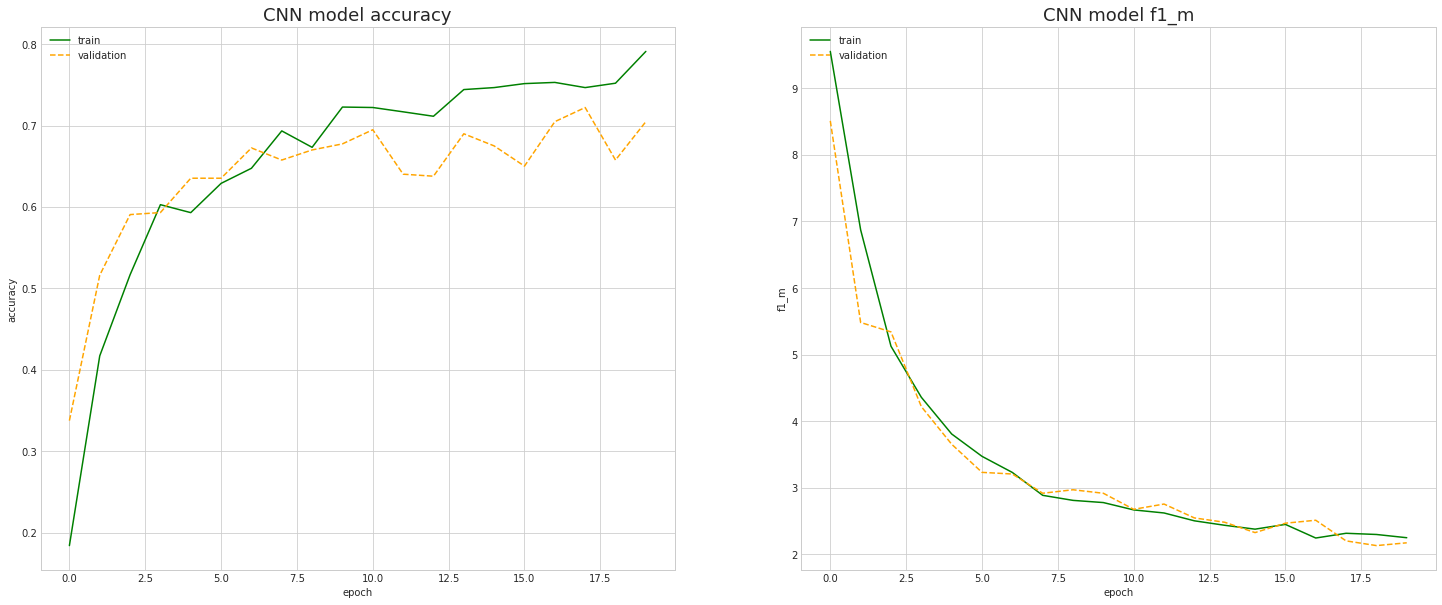

In [44]:
plot_history_scores(
    dict_history = history_resnet, 
    first_score = "accuracy", 
    second_score = "f1_m")

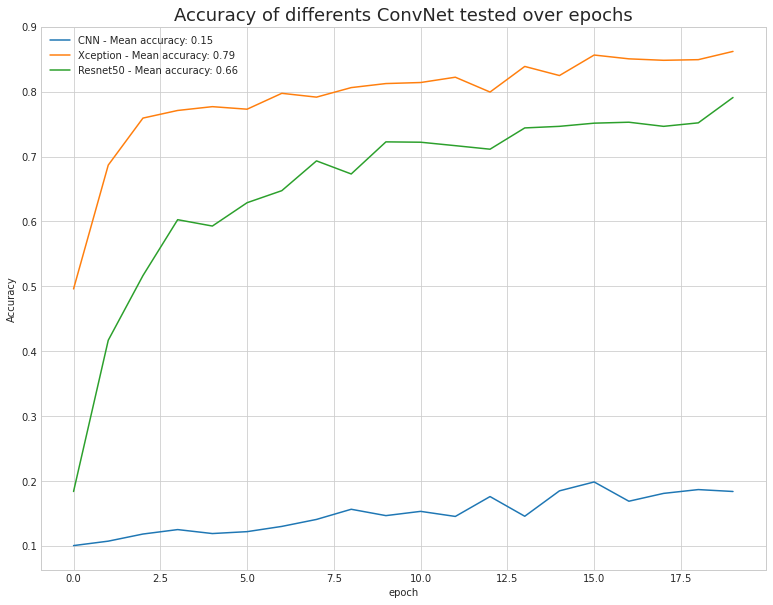

In [45]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(13,10))
    plt.plot(history.history['accuracy'],
             label='CNN - Mean accuracy: {:.2f}'.format(
                 np.mean(history.history['accuracy'])))
    plt.plot(history_xcept.history['accuracy'],
             label='Xception - Mean accuracy: {:.2f}'.format(
                 np.mean(history_xcept.history['accuracy'])))
    plt.plot(history_resnet.history['accuracy'],
             label='Resnet50 - Mean accuracy: {:.2f}'.format(
                 np.mean(history_resnet.history['accuracy'])))
    plt.title('Accuracy of differents ConvNet tested over epochs',
              fontsize=18)
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(loc='upper left')
    plt.show()

A cette étape, sans amélioration des paramètres et sans fine-tuning, **le modèle Xception offre les meilleurs résultats**. Nous conserverons donc ce modèle pour la suite.

## <span style="color:#343434" id="section_3_4">3.4. Optimization des paramètres sur la couche classifier du modèle Xception</span>

Ici nous allons utiliser `kerastuner` pour améliorer les paramètres de la couche que nous avons ajouté au moèle Xception de Keras et séléctionner les meilleurs.

In [46]:
def model_builder(hp):
    # Load base model
    xception_model = tf.keras.applications.xception.Xception(
        weights='imagenet',
        include_top=False,
        pooling='avg',
        input_shape=(299,299,3))
    
    for layer in xception_model.layers:
        layer.trainable = False
    
    base_output = xception_model.output
    
    # Tune dense units
    hp_units = hp.Int('dense_units',
                      min_value=32,
                      max_value=300,
                      step=32,
                      default=128)

    base_output = Dense(units=hp_units, 
                        activation='relu')(base_output)
    
    base_output = Dropout(0.2)(base_output)
    
    # Output : new classifier
    predictions = Dense(num_breeds, activation='softmax')(base_output)

    # Define new model
    my_xcept_model = Model(inputs=xception_model.input,
                       outputs=predictions)
    
    # Tune learning rate
    hp_learning_rate = hp.Choice(
        name='learning_rate',
        values=[1e-2, 1e-3, 1e-4])

    my_xcept_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy", f1_m])
    
    return my_xcept_model

In [ ]:
# Tune the learning rate for the optimizer
# Constuct the tuner of kerastuner
tuner = kt.RandomSearch(
    model_builder, 
    objective='val_accuracy',
    max_trials=5)

# Define a early stopping
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5)

# Search best params
tuner.search(
    train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='training'),
    validation_data=train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='validation'),
    epochs=10,
    callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("-" * 50)
print("Xception Hyperparameters optimization :")
print("-" * 50)
print(f"""
Best learning rate : {best_hps.get('learning_rate')}.\n
Best Dense units : {best_hps.get('dense_units')}.""")

Trial 3 Complete [00h 06m 38s]
val_accuracy: 0.7841191291809082

Best val_accuracy So Far: 0.7990074157714844
Total elapsed time: 00h 20m 00s

Search: Running Trial #4

Hyperparameter    |Value             |Best Value So Far 
dense_units       |288               |256               
learning_rate     |0.001             |0.001             

Epoch 1/10
101/101 [==============================] - 38s 378ms/step - loss: 1.1349 - accuracy: 0.6525 - f1_m: 3.9890 - val_loss: 0.8620 - val_accuracy: 0.7395 - val_f1_m: 3.1708
Epoch 4/10
101/101 [==============================] - 39s 390ms/step - loss: 1.0162 - accuracy: 0.6706 - f1_m: 3.3539 - val_loss: 0.8104 - val_accuracy: 0.7568 - val_f1_m: 2.7634
Epoch 5/10
101/101 [==============================] - 39s 388ms/step - loss: 0.9257 - accuracy: 0.6974 - f1_m: 2.9598 - val_loss: 0.7732 - val_accuracy: 0.7543 - val_f1_m: 2.5497
Epoch 6/10
101/101 [==============================] - 40s 398ms/step - loss: 0.8799 - accuracy: 0.7185 - f1_m: 2.8501 - va

Une fois les meilleurs paramètres trouvés, **on peut ré-entrainer le modèle grâce au tuner**, sur 30 époques avant de le sauvegarder pour les prochaines améliorations *(fine-tuning)* :

In [48]:
hypermodel = tuner.hypermodel.build(best_hps)
hypermodel.fit(
    train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='training'), 
    epochs=30,
    validation_data=train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='validation'),
    verbose=2)
hypermodel.save('xception_hypermodel.h5')
print("Model saved")

101/101 - 39s - loss: 0.4570 - accuracy: 0.8532 - f1_m: 1.7184 - val_loss: 0.6516 - val_accuracy: 0.7891 - val_f1_m: 1.8765
Epoch 10/30
101/101 - 39s - loss: 0.4584 - accuracy: 0.8544 - f1_m: 1.6926 - val_loss: 0.6842 - val_accuracy: 0.7593 - val_f1_m: 1.8526
Epoch 11/30
101/101 - 38s - loss: 0.4488 - accuracy: 0.8519 - f1_m: 1.6522 - val_loss: 0.7282 - val_accuracy: 0.7593 - val_f1_m: 1.7800
Epoch 12/30
101/101 - 39s - loss: 0.3562 - accuracy: 0.8767 - f1_m: 1.5636 - val_loss: 0.6249 - val_accuracy: 0.7965 - val_f1_m: 1.6987
Epoch 13/30
101/101 - 39s - loss: 0.4135 - accuracy: 0.8612 - f1_m: 1.5863 - val_loss: 0.6173 - val_accuracy: 0.7841 - val_f1_m: 1.7351
Epoch 14/30
101/101 - 38s - loss: 0.3711 - accuracy: 0.8711 - f1_m: 1.5986 - val_loss: 0.6330 - val_accuracy: 0.7667 - val_f1_m: 1.7347
Epoch 15/30
101/101 - 39s - loss: 0.3634 - accuracy: 0.8742 - f1_m: 1.5801 - val_loss: 0.6844 - val_accuracy: 0.8040 - val_f1_m: 1.6713
Epoch 16/30
101/101 - 39s - loss: 0.3456 - accuracy: 0.8804 

# <span style="color:#343434" id="section_4">4. Xception fine tuning</span>
Comme nous l'avons vu dans le schéma de l'architecture Xception, ce modèle dispose de 3 blocs : le flux, d'entrée, le flux moyen et le flux de sortie. **Nous allons ré-entrainer le dernier bloc sur le modèle sauvegardé** dont les paramètres ont été améliorés :

In [49]:
def xception_fine_tune(nb_layers):
    # Load the pre trained model
    hypermodel_t = load_model('./xception_hypermodel.h5', custom_objects={"f1_m": f1_m})
    
    # re train the last layers
    for i, layer in enumerate(hypermodel_t.layers):
        if i < nb_layers:
            layer.trainable = False
        else:
            layer.trainable = True
            
    # Compile model
    hypermodel_t.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy", f1_m])
    
    return hypermodel_t

In [50]:
# Define a early stopping
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5)

# Dont train the 115 first layers
my_tuned_xcept_model = xception_fine_tune(115)
fine_tuned_history = my_tuned_xcept_model.fit(
    train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        shuffle=False,
        subset='training'), 
    epochs=20,
    validation_data=train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        shuffle=False,
        subset='validation'),
    callbacks=[stop_early],
    verbose=2)

Epoch 1/20
101/101 - 43s - loss: 1.0658 - accuracy: 0.6729 - f1_m: 2.5118 - val_loss: 1.2753 - val_accuracy: 0.6675 - val_f1_m: 1.6833
Epoch 2/20
101/101 - 39s - loss: 0.6839 - accuracy: 0.7788 - f1_m: 1.9442 - val_loss: 0.8622 - val_accuracy: 0.7816 - val_f1_m: 1.4104
Epoch 3/20
101/101 - 40s - loss: 0.4906 - accuracy: 0.8451 - f1_m: 1.6393 - val_loss: 1.1607 - val_accuracy: 0.7519 - val_f1_m: 1.4669
Epoch 4/20
101/101 - 39s - loss: 0.4854 - accuracy: 0.8445 - f1_m: 1.5589 - val_loss: 1.4136 - val_accuracy: 0.6948 - val_f1_m: 1.4071
Epoch 5/20
101/101 - 40s - loss: 0.3688 - accuracy: 0.8761 - f1_m: 1.4324 - val_loss: 1.3075 - val_accuracy: 0.7320 - val_f1_m: 1.5074
Epoch 6/20
101/101 - 39s - loss: 0.3394 - accuracy: 0.8996 - f1_m: 1.3677 - val_loss: 0.7826 - val_accuracy: 0.7816 - val_f1_m: 1.4474
Epoch 7/20
101/101 - 39s - loss: 0.2757 - accuracy: 0.9052 - f1_m: 1.2819 - val_loss: 1.4039 - val_accuracy: 0.6526 - val_f1_m: 1.5261


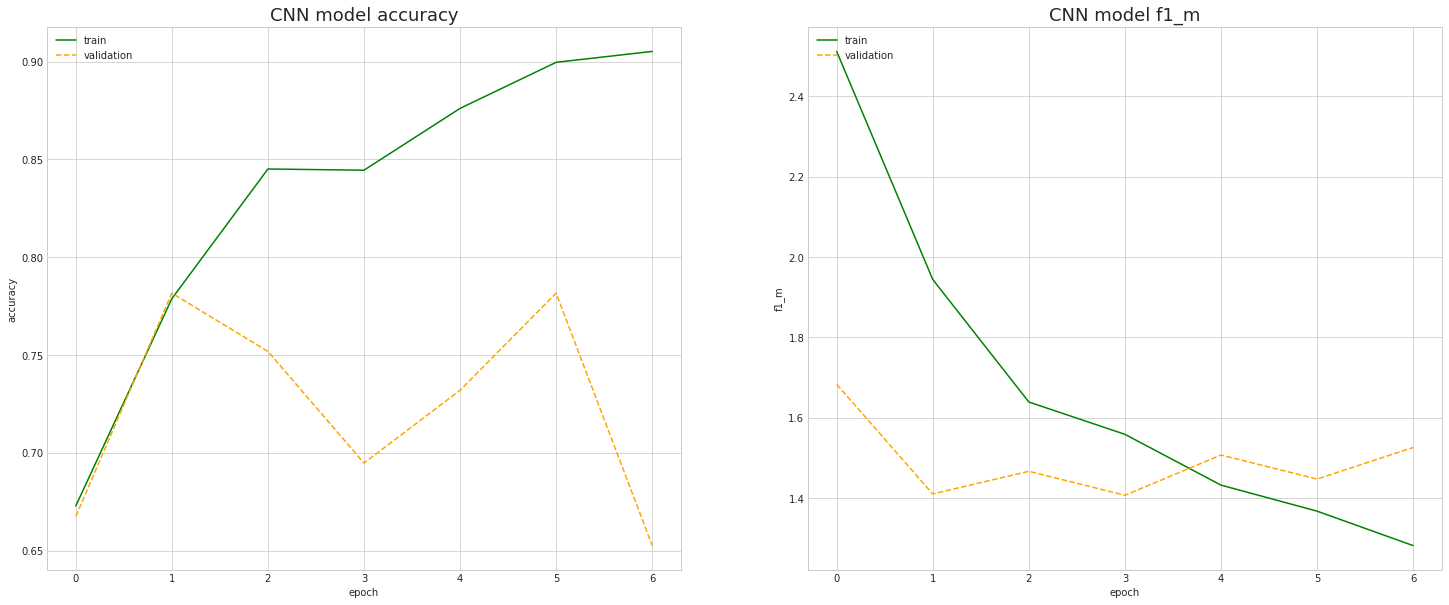

In [51]:
plot_history_scores(
    dict_history = fine_tuned_history, 
    first_score = "accuracy", 
    second_score = "f1_m")

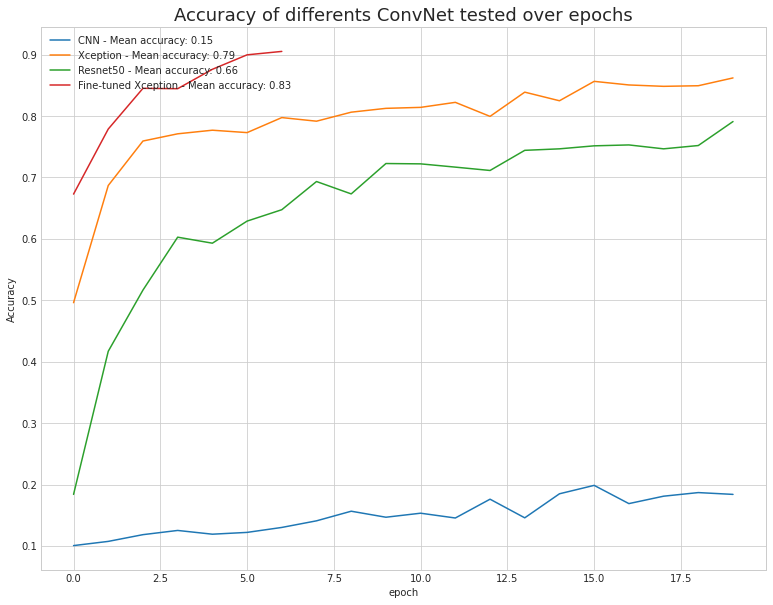

In [52]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(13,10))
    plt.plot(history.history['accuracy'],
             label='CNN - Mean accuracy: {:.2f}'.format(
                 np.mean(history.history['accuracy'])))
    plt.plot(history_xcept.history['accuracy'],
             label='Xception - Mean accuracy: {:.2f}'.format(
                 np.mean(history_xcept.history['accuracy'])))
    plt.plot(history_resnet.history['accuracy'],
             label='Resnet50 - Mean accuracy: {:.2f}'.format(
                 np.mean(history_resnet.history['accuracy'])))
    plt.plot(fine_tuned_history.history['accuracy'],
             label='Fine-tuned Xception - Mean accuracy: {:.2f}'.format(
                 np.mean(fine_tuned_history.history['accuracy'])))
    plt.title('Accuracy of differents ConvNet tested over epochs',
              fontsize=18)
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(loc='upper left')
    plt.show()

On voit ici que le meilleur modèle testé est le modèle **Xception pré-entrainé avec fine-tuning**. Nous allons donc réaliser les **évaluations sur nos données test**.

# <span style="color:#343434" id="section_5">5. Evaluation Xception fine tuned sur données test</span>
Nous allons évaluer ce dernier moèle sur les données test générées grâce au `ImageDataGenerator` de Keras définit préalablement :

In [53]:
# Model evaluation on test set
xception_eval = fine_tuned_history.model.evaluate(
    test_datagen.flow(
        x_test, y_test,
        batch_size=16,
        shuffle=False),
    verbose=1)
print("-" * 50)
print("Xception model evaluation :")
print("-" * 50)
print('Test Loss: {:.3f}'.format(xception_eval[0]))
print('Test Accuracy: {:.3f}'.format(xception_eval[1]))
print('Test F1 score: {:.3f}'.format(xception_eval[2]))

32/32 [==============================] - 3s 82ms/step - loss: 1.2276 - accuracy: 0.7228 - f1_m: 1.3985
--------------------------------------------------
Xception model evaluation :
--------------------------------------------------
Test Loss: 1.228
Test Accuracy: 0.723
Test F1 score: 1.398


Puis nous allons éditer la **matrice de confusion** et le **rapport de classification** grâce aux données prédites :

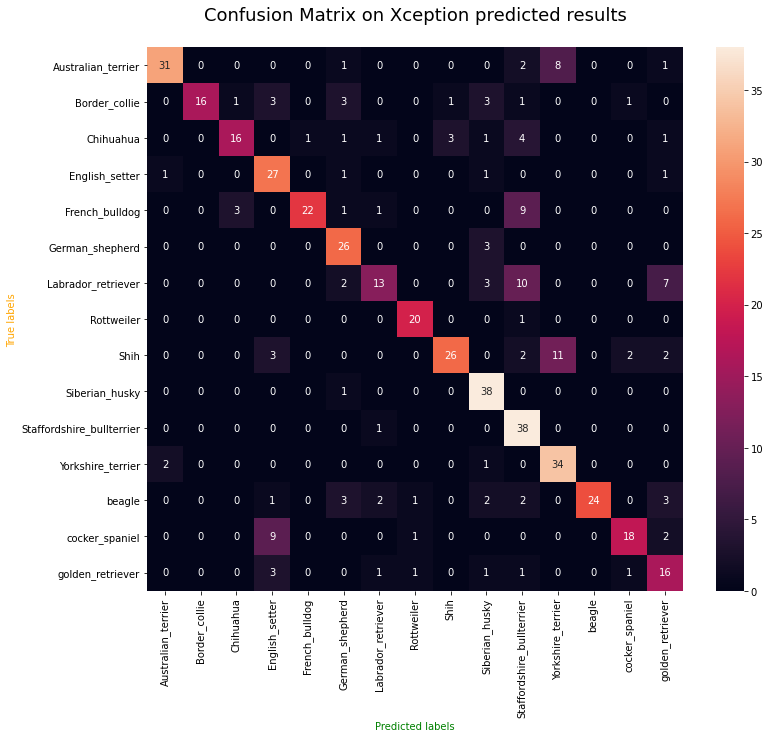

In [54]:
# Make predictions
Y_pred = fine_tuned_history.model.predict(
    test_datagen.flow(
        x_test, y_test,
        batch_size=16,
        shuffle=False))
y_pred = np.argmax(Y_pred, axis=1)

# Inverse transform of encoding
y_pred_s = encoder.inverse_transform(y_pred)
y_test_s = encoder.inverse_transform(y_test)

# Confusion Matrix
cf_matrix = confusion_matrix(y_test, y_pred)

fig = plt.figure(figsize=(12,10))
ax = sns.heatmap(cf_matrix, annot=True)
ax.set_xlabel("Predicted labels", color="g")
ax.set_ylabel("True labels", color="orange")
ax.xaxis.set_ticklabels(encoder.classes_, 
                        rotation='vertical')
ax.yaxis.set_ticklabels(encoder.classes_,
                        rotation='horizontal')
plt.title("Confusion Matrix on Xception predicted results\n",
          fontsize=18)
plt.show()

In [55]:
# Classification report
print(classification_report(
    y_test, y_pred, 
    target_names=sorted(set(y_test_s))))

                           precision    recall  f1-score   support

       Australian_terrier       0.91      0.72      0.81        43
            Border_collie       1.00      0.55      0.71        29
                Chihuahua       0.80      0.57      0.67        28
           English_setter       0.59      0.87      0.70        31
           French_bulldog       0.96      0.61      0.75        36
          German_shepherd       0.67      0.90      0.76        29
       Labrador_retriever       0.68      0.37      0.48        35
               Rottweiler       0.87      0.95      0.91        21
                     Shih       0.87      0.57      0.68        46
           Siberian_husky       0.72      0.97      0.83        39
Staffordshire_bullterrier       0.54      0.97      0.70        39
        Yorkshire_terrier       0.64      0.92      0.76        37
                   beagle       1.00      0.63      0.77        38
           cocker_spaniel       0.82      0.60      0.69     

La matrice de confusion et le rapport de classification nous indiquent que les résultats sont satisfaisants.ccuracy globale sur le jeu de test est de 0.72 et la matrice présente bien les couples predict / true majoritaires en diagonale.Nous allons visualiser quelques-unes de ces prédictions avec leurs labels :

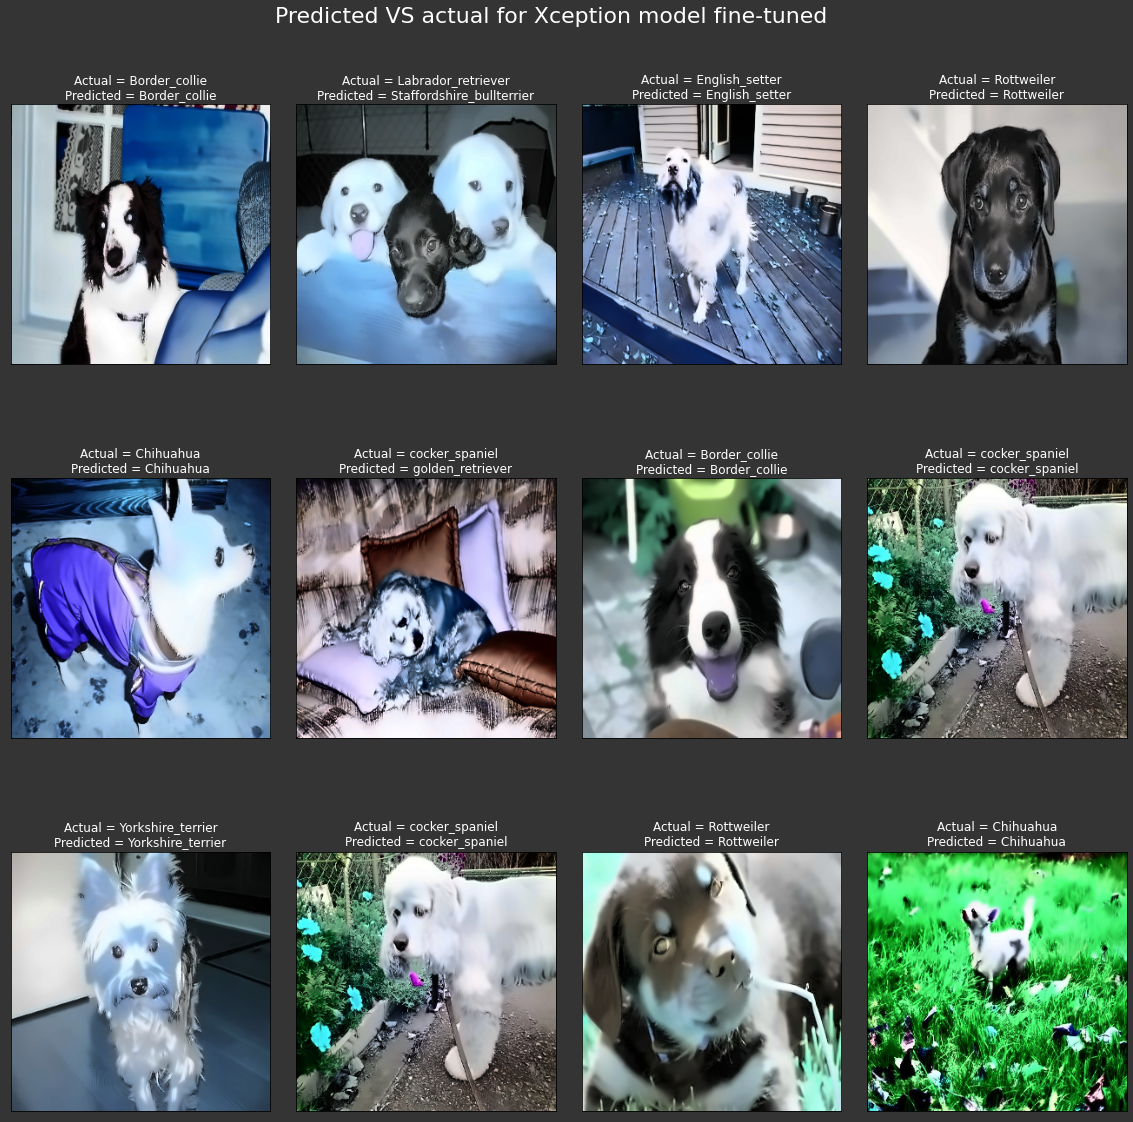

In [56]:
fig = plt.figure(1, figsize=(20,20))
fig.patch.set_facecolor('#343434')
plt.suptitle("Predicted VS actual for Xception model fine-tuned",
             y=.92, fontsize=22,
             color="white")

n = 0

for i in range(12):
    n+=1
    r = int(np.random.randint(0, x_test.shape[0], 1))
    plt.subplot(3,4,n)
    plt.subplots_adjust(hspace = 0.1, wspace = 0.1)
    plt.imshow(image.array_to_img(x_test[r]))
    plt.title('Actual = {}\nPredicted = {}'.format(y_test_s[r] , y_pred_s[r]),
              color="white")
    plt.xticks([]) , plt.yticks([])
    
plt.show()

On voit parfaitement ainsi que les prédictions finales sont bonnes dans la plupart des cas. 

# <span style="color:#343434" id="section_6">6. Interface de prédiction sur de nouvelles données</span>
A présent, nous allons développer un script pour permettre la prédiction de la race du chien à partir d'une photo. Notre modèle pré-entrainé servira de base. Pour cela, nous allons utiliser `Gradio` pour importer les images *(inputs)* et appliquer notre classifier afin de retourner la prédiction

In [57]:
# Save the last model
fine_tuned_history.model.save('xception_trained_model.h5')
print("Last model saved")

Last model saved


In [58]:
# Load model
model = load_model('./xception_hypermodel.h5', custom_objects={"f1_m": f1_m})

# Define the full prediction function
def breed_prediction(inp):
    # Convert to RGB
    img = cv.cvtColor(inp,cv.COLOR_BGR2RGB)
    # Resize image
    dim = (299, 299)
    img = cv.resize(img, dim, interpolation=cv.INTER_LINEAR)
    # Equalization
    img_yuv = cv.cvtColor(img,cv.COLOR_BGR2YUV)
    img_yuv[:,:,0] = cv.equalizeHist(img_yuv[:,:,0])
    img_equ = cv.cvtColor(img_yuv, cv.COLOR_YUV2RGB)
    # Apply non-local means filter on test img
    dst_img = cv.fastNlMeansDenoisingColored(
        src=img_equ,
        dst=None,
        h=10,
        hColor=10,
        templateWindowSize=7,
        searchWindowSize=21)

    # Convert modified img to array
    img_array = keras.preprocessing.image.img_to_array(dst_img)
    
    # Apply preprocess Xception
    img_array = img_array.reshape((-1, 299, 299, 3))
    img_array = tf.keras.applications.xception.preprocess_input(img_array)
    
    # Predictions
    prediction = model.predict(img_array).flatten()
    
    #return prediction
    return {encoder.classes_[i]: float(prediction[i]) for i in range(num_breeds)}

# Construct the interface
image = gr.inputs.Image(shape=(299,299))
label = gr.outputs.Label(num_top_classes=3)

gr.Interface(
    fn=breed_prediction,
    inputs=image,
    outputs=label,
    capture_session=True
).launch(share=True)

Running locally at: http://127.0.0.1:7860/
This share link will expire in 24 hours. If you need a permanent link, visit: https://gradio.app/introducing-hosted (NEW!)
Running on External URL: https://10453.gradio.app
Interface loading below...


(<Flask 'gradio.networking'>,
 'http://127.0.0.1:7860/',
 'https://10453.gradio.app')

Après plusieurs test sur notre programme, on s'apperçoit que les résultats sont bons et que les prédictions sur des images inconnues sont exactes.

Ci-dessous, l'Iframe de l'**application en ligne développée à partir du meilleur modèle Xception et déployé sur Heroku** (https://dogs-breeds-detection-cnn.herokuapp.com/)

In [62]:
from IPython.display import IFrame
IFrame('https://dogs-breeds-detection-cnn.herokuapp.com/', width=1000, height=900)